# GCP Vertex AI.

The following are the step that I followed to setup GCP Vertex AI.

* Enable appropriate (Vertex AI) API.
* Create a notebook instance.
* Create a cloud storage if necessary.

The main components of GCP Vertex AI are:
* Datasets
* Features
* Labelling tasks
* Notebooks
* AutoML
* Pipelines
  
This notebook demonstrates how one could train and deploy the model on GCP Vertex AI.


### Local machine training.


In [1]:
# Importing libraries.
import os
import torch
import pandas as pd
import torch.optim as optim
from trainer.misc import net, data, train, test, utils, config

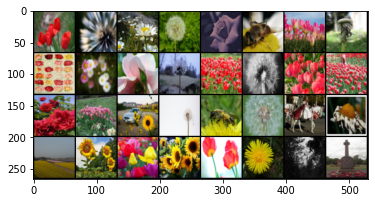

In [2]:
os.environ['TORCH_HOME'] = config.config.model_dir
DEVICE = torch.device(config.config.device)
_data = data.Data(data_dir=config.config.data_dir, train_batch_size=config.config.train_batch_size, test_batch_size=config.config.test_batch_size)
_data.visualize()
TRAIN_LOADER, TEST_LOADER = _data.get_loaders()
MODEL = net.Resnet18().get_model(num_classes=config.config.num_classes).to(DEVICE)
OPTIMIZER = optim.SGD(MODEL.parameters(), lr=config.config.lr, momentum=config.config.momentum)
CRITERION = torch.nn.CrossEntropyLoss()
SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, 'min', patience=config.config.patience)

In [3]:
train_loss, saved_path = train.Train(
    model=MODEL,
    train_loader=TRAIN_LOADER,
    optimizer=OPTIMIZER,
    criterion=CRITERION,
    scheduler=SCHEDULER,
    epochs=config.config.epochs,
    device=DEVICE,
    save_path_dir=config.config.save_path_dir,
    verbose=config.config.verbose,
    verbose_step=config.config.verbose_step
).train()


DEVICE - cuda || EPOCHS - 10 || LEARNING RATE - 0.001.


EPOCH - 1/10 || START AT - 16:07:18 29|06|2021 || LEARNING RATE - 0.001

/home/tyche/miniconda3/envs/ai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
	EPOCH - 1/10 || TRAIN LOSS - 0.91934 || TIME ELAPSED - 20.44s.


EPOCH - 2/10 || START AT - 16:07:38 29|06|2021 || LEARNING RATE - 0.001

	EPOCH - 2/10 || TRAIN LOSS - 0.39297 || TIME ELAPSED - 20.13s.


EPOCH - 3/10 || START AT - 16:07:58 29|06|2021 || LEARNING RATE - 0.001

	EPOCH - 3/10 || TRAIN LOSS - 0.21758 || TIME ELAPSED - 19.98s.


EPOCH - 4/10 || START AT - 16:08:18 29|06|2021 || LEARNING RATE - 0.001

	EPOCH - 4/10 || TRAIN LOSS 

In [4]:
image_set, label_set, pred_set, model = test.Test(
    model=MODEL,
    test_loader=TEST_LOADER,
    device=DEVICE,
    save_path=saved_path,
    test_run=config.config.test_run
).test()

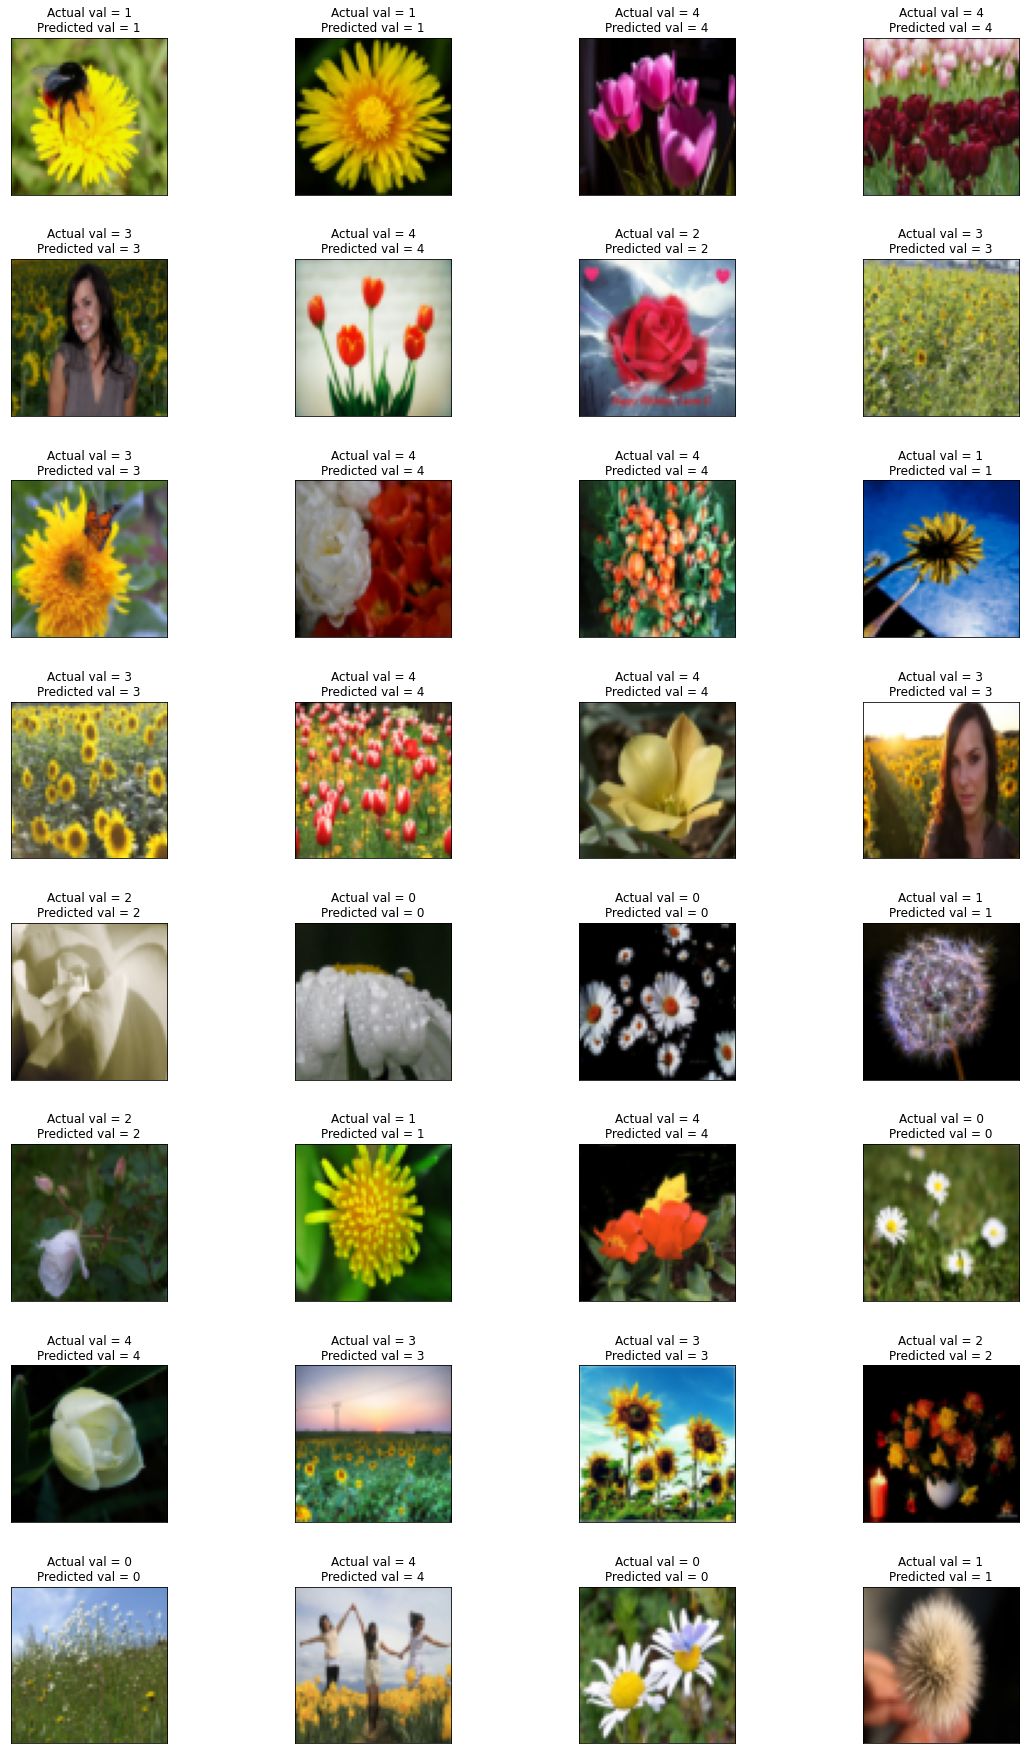

In [5]:
utils.plot_output(image_set, label_set, pred_set)

### Training using VertexAI

In [6]:
# Cell must be executed  only if you are using google colab or local system.
import sys
from dotenv import load_dotenv
load_dotenv()
if "google.colab" in sys.modules:
    # Google colab authentication to use GCP.
    from google.colab import auth as google_auth
    google_auth.authenticate_user()
else:
    # Loacl system authentication to use GCP.
    %env GOOGLE_APPLICATION_CREDENTIALS {os.getenv('GOOGLE_APPLICATION_CREDENTIALS', '')}

env: GOOGLE_APPLICATION_CREDENTIALS=./__secrets__/project-v2-318004-b04d33cb80ee.json


In [15]:
# Import libraries.
from datetime import datetime
from google.cloud import storage
from google.cloud import aiplatform

In [8]:
# # Rename the folders and push it to the storage bucket if you are running for thee first time and the data is freshly installed.
# utils.rename_files(data_dir=config.config.data_dir)
# utils.get_csv(data_dir=config.config.data_dir, store_path=config.config.data_dir+"flowers.csv"))
# !gsutil -m cp -r ./__data__/flower_photos gs://vertexai_bucket/datasets
# !gsutil -m cp -r ./__data__/flower_photos/flowers.csv gs://vertexai_bucket/datasets/flower_photos

In [9]:
# # Run this cell only if you are using google colab.
# PROJECT_ID = '[your-project-id]' # TODO (Set to your GCP Project name).
# BUCKET_NAME = '[your-bucket-name]' # TODO (Set to your GCS Bucket name).
# REGION = '[region]' # TODO (Set to your Region).
# !gcloud config set project {PROJECT_ID}

In [10]:
# # Run this cell if you want to download data and record models.
# !mkdir __data__
# !mkdir __models__
# !gsutil -m cp -r gs://vertexai_bucket/datasets/flower_photos .  

In [11]:
# Initializing VertexAI and experiments.
EXPERIMENT_NAME = "flower-experiment"
aiplatform.init(
        project=os.getenv('PROJECT_ID', ''), # Porject ID.
        location=os.getenv('REGION', ''), # VertexAI region, default is 'us-central1'.
        staging_bucket=os.getenv('BUCKET_NAME', ''), # Bucket in the same region defined by VertexAI.
        experiment=EXPERIMENT_NAME, # Experiment name.
    )

In [12]:
# Run this to create a package distribution and upload it to GCS.
!python setup.py sdist --formats=gztar
!gsutil cp ./dist/trainer-0.1.tar.gz gs://vertexai_bucket/setups/flower_classification/

running sdist
running egg_info
writing trainer.egg-info/PKG-INFO
writing dependency_links to trainer.egg-info/dependency_links.txt
writing requirements to trainer.egg-info/requires.txt
writing top-level names to trainer.egg-info/top_level.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'
running check


creating trainer-0.1
creating trainer-0.1/trainer
creating trainer-0.1/trainer.egg-info
creating trainer-0.1/trainer/misc
copying files to trainer-0.1...
copying README.md -> trainer-0.1
copying setup.py -> trainer-0.1
copying trainer/__init__.py -> trainer-0.1/trainer
copying trainer/task.py -> trainer-0.1/trainer
copying trainer.egg-info/PKG-INFO -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/SOURCES.txt -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/dependency_links.txt -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/requires.txt -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/top_level.

In [13]:
def create_custom_job_pkg(project, location, display_name, container_image_uri, gcs_package_uri, entry_point, replica_count, machine_type, accelerator_type, accelerator_count, api_endpoint="us-central1-aiplatform.googleapis.com",
):
    client_options = {"api_endpoint": api_endpoint}
    client = aiplatform.gapic.JobServiceClient(client_options=client_options)
    custom_job = {
        "display_name": display_name,
        "job_spec": {
            "worker_pool_specs": [
                {
                    "machine_spec": {
                        "machine_type": machine_type,
                        "accelerator_type": accelerator_type,
                        "accelerator_count": accelerator_count,
                    },
                    "disk_spec":{
                        "boot_disk_type": "pd-ssd",
                        "boot_disk_size_gb": 100
                    },
                    "replica_count": replica_count,
                    "python_package_spec":{
                        "executor_image_uri": container_image_uri,
                        "package_uris": [
                            gcs_package_uri
                        ],
                        "python_module": entry_point,
                        "args": [],
                        "env": []
                    }
                }
            ],
        },
        
    }
    parent = f"projects/{project}/locations/{location}"
    response = client.create_custom_job(parent=parent, custom_job=custom_job)
    print("response:", response)

project, location, bucket_uri = os.getenv("PROJECT_ID", ''), os.getenv("REGION", ''), os.getenv("BUCKET_URI", '')
create_custom_job_pkg(
    project=project,
    location=location,
    display_name="flower_classification",
    container_image_uri="us-docker.pkg.dev/vertex-ai/training/pytorch-gpu.1-7:latest",
    gcs_package_uri=f"{bucket_uri}/setups/flower_classification/trainer-0.1.tar.gz",
    entry_point="trainer.task",
    replica_count=1,
    machine_type="n1-standard-4",
    accelerator_type="NVIDIA_TESLA_K80",
    accelerator_count=1,
)

response: name: "projects/623494311191/locations/us-central1/customJobs/2238381373779869696"
display_name: "flower_classification"
job_spec {
  worker_pool_specs {
    machine_spec {
      machine_type: "n1-standard-4"
      accelerator_type: NVIDIA_TESLA_K80
      accelerator_count: 1
    }
    replica_count: 1
    disk_spec {
      boot_disk_type: "pd-ssd"
      boot_disk_size_gb: 100
    }
    python_package_spec {
      executor_image_uri: "us-docker.pkg.dev/vertex-ai/training/pytorch-gpu.1-7:latest"
      package_uris: "gs://vertexai_bucket/setups/flower_classification/trainer-0.1.tar.gz"
      python_module: "trainer.task"
    }
  }
}
state: JOB_STATE_PENDING
create_time {
  seconds: 1624963250
  nanos: 148555000
}
update_time {
  seconds: 1624963250
  nanos: 148555000
}



INFO:root:Resource flower-experiment-custom-training-run-20210629173408 not found.
INFO:root:Creating Resource flower-experiment-custom-training-run-20210629173408
INFO:root:Resource flower-experiment-custom-training-run-20210629173408-metrics not found.
INFO:root:Creating Resource flower-experiment-custom-training-run-20210629173408-metrics


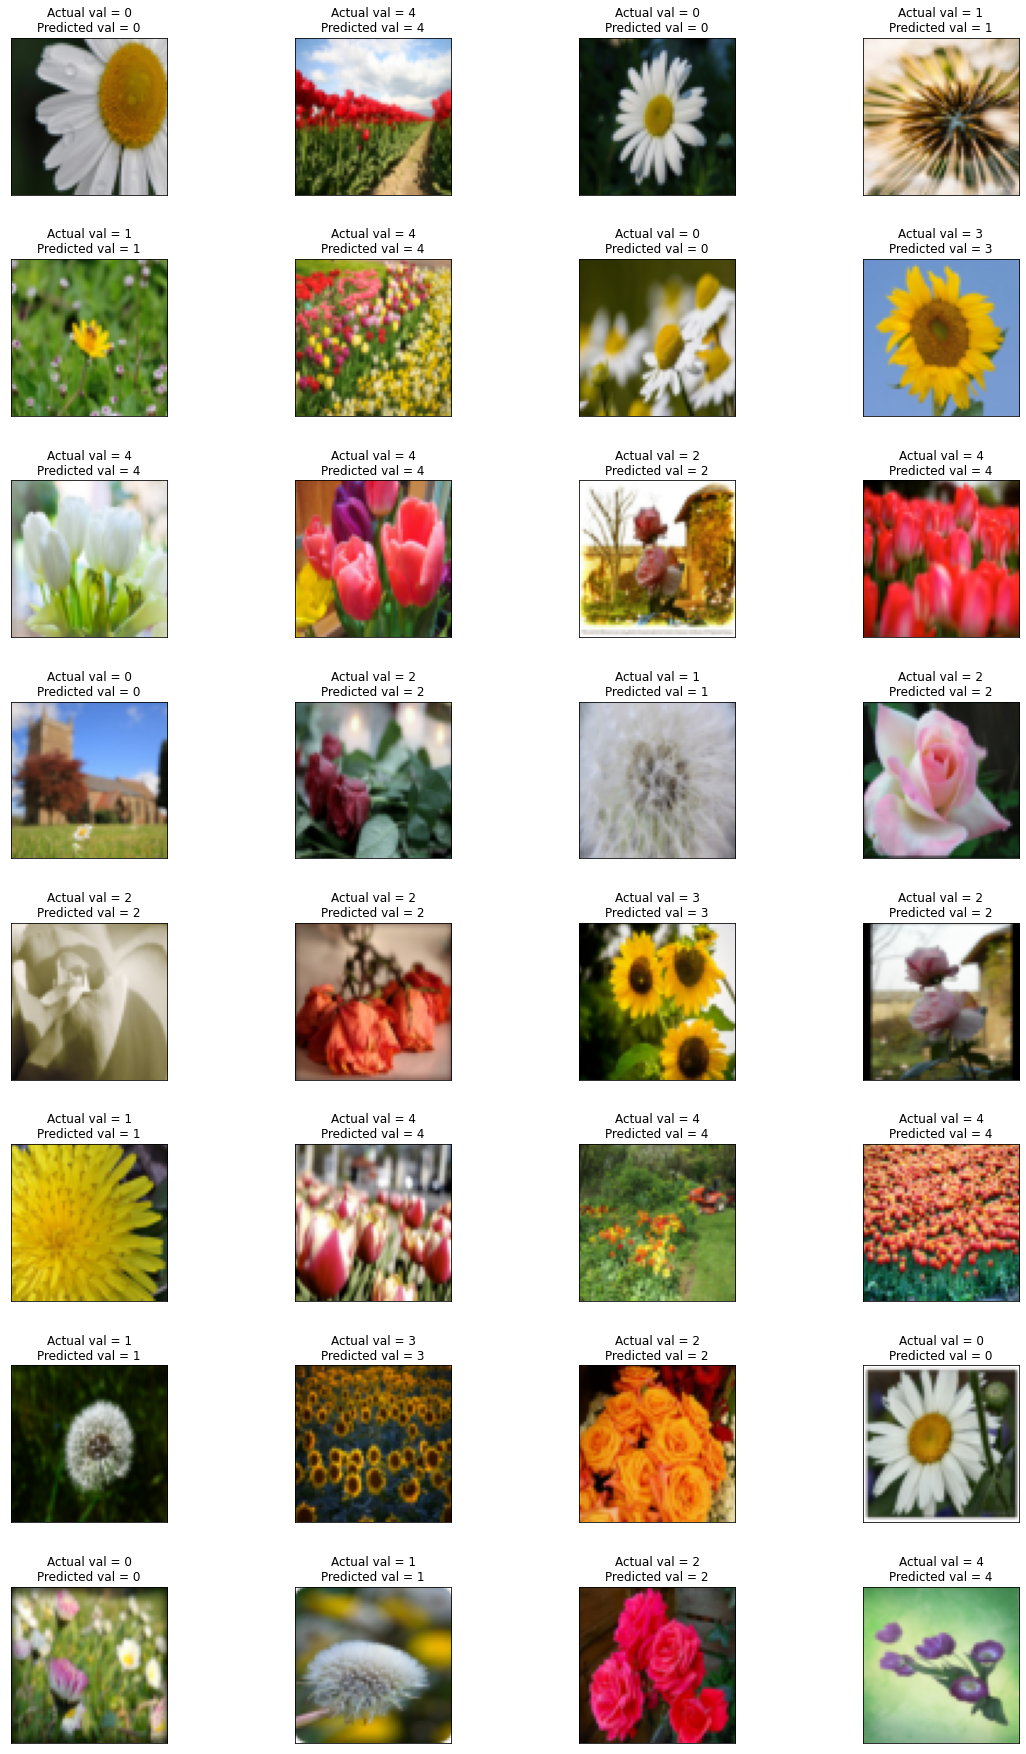

In [16]:
def inference(model=None, cloud_path=None, saved_path=None, model_name=None, test_loader=None, device=None, test_run=None):
    file_name = model_name.split('.')[0]
    os.system(f"gsutil cp {cloud_path+model_name} {saved_path}")
    os.system(f"gsutil cp {cloud_path+file_name+'_log.csv'} {saved_path}")
    os.system(f"gsutil cp {cloud_path+file_name+'_param.csv'} {saved_path}")
    csv_file_param = pd.read_csv(saved_path+file_name+'_param.csv')
    csv_file_log = pd.read_csv(saved_path+file_name+'_log.csv')
    TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
    EXPERIMENT_RUN_NAME = "custom-training-run-" + TIMESTAMP
    aiplatform.start_run(EXPERIMENT_RUN_NAME)
    parameters = {"epochs": 5, "lr": 1e-3}
    aiplatform.log_params(parameters)
    aiplatform.log_metrics(
        {"Training Loss": row["Training Loss"] for _, row in csv_file_log.iterrows()}
    )
    image_set, label_set, pred_set, model = test.Test(
        model=model,
        test_loader=test_loader,
        device=device,
        save_path=saved_path+model_name,
        test_run=test_run
    ).test()
    utils.plot_output(image_set, label_set, pred_set)

inference(model=MODEL, cloud_path=f"gs://vertexai_bucket{config.config.save_path_dir_cloud}", saved_path=config.config.save_path_dir, model_name="2O5FGMRB86.pth", test_loader=TEST_LOADER, device=DEVICE, test_run=config.config.test_run)